# Xây dựng Phần Mềm Chuyển Ảnh Thành Tranh Vẽ
## Đề tài 4 - Xử Lý Ảnh (INT13146)

**Nội dung:** Dùng phát hiện biên + chuyển đổi mức xám + kỹ thuật làm mịn để tạo hiệu ứng vẽ tay

**Công nghệ sử dụng:**
- NumPy: Tính toán ma trận
- Matplotlib: Hiển thị ảnh
- PIL: Đọc/ghi file ảnh
- Các thuật toán tự triển khai: Gaussian blur, Sobel edge detection, Bilateral filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
from typing import Tuple, Optional
import warnings
import math

# Phát hiện môi trường Colab để xử lý upload file tương ứng
try:
    from google.colab import files as colab_files
    IN_COLAB = True
except Exception:
    colab_files = None
    IN_COLAB = False

# Phát hiện Numba để tăng tốc (nếu có)
try:
    import numba as nb
    HAVE_NUMBA = True
    print("[v0] Numba detected: JIT acceleration enabled where available")
except Exception:
    HAVE_NUMBA = False

warnings.filterwarnings('ignore')

print("[v0] Các thư viện đã được import thành công")

[v0] Các thư viện đã được import thành công


## Bước 1: Triển khai các hàm xử lý ảnh cơ bản

In [3]:
class ImageProcessor:
    """Lớp xử lý ảnh với các thuật toán tự triển khai"""

    @staticmethod
    def load_image(image_path: str) -> np.ndarray:
        """
        Đọc ảnh từ file

        Args:
            image_path: Đường dẫn tới file ảnh

        Returns:
            Mảng numpy chứa dữ liệu ảnh (0-255)
        """
        img = Image.open(image_path)
        img_array = np.array(img, dtype=np.float32)
        print(f"[v0] Ảnh được tải: {image_path}")
        print(f"[v0] Kích thước ảnh: {img_array.shape}")
        return img_array

    @staticmethod
    def save_image(image_array: np.ndarray, output_path: str) -> None:
        """
        Lưu ảnh vào file

        Args:
            image_array: Mảng numpy chứa dữ liệu ảnh
            output_path: Đường dẫn lưu file
        """
        # Chuẩn hóa giá trị về 0-255
        img_normalized = np.clip(image_array, 0, 255).astype(np.uint8)
        img = Image.fromarray(img_normalized)
        img.save(output_path)
        print(f"[v0] Ảnh đã được lưu: {output_path}")

    @staticmethod
    def to_grayscale(image: np.ndarray) -> np.ndarray:
        """
        Chuyển đổi ảnh RGB sang mức xám
        Công thức: Gray = 0.299*R + 0.587*G + 0.114*B

        Args:
            image: Ảnh RGB (H, W, 3) hoặc ảnh xám (H, W)

        Returns:
            Ảnh mức xám (H, W)
        """
        if len(image.shape) == 2:
            print("[v0] Ảnh đã là mức xám")
            return image

        # Áp dụng công thức chuyển đổi mức xám
        gray = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
        print(f"[v0] Chuyển đổi sang mức xám thành công")
        return gray

    @staticmethod
    def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
        """
        Tạo kernel Gaussian

        Args:
            size: Kích thước kernel (size x size)
            sigma: Độ lệch chuẩn

        Returns:
            Kernel Gaussian đã chuẩn hóa
        """
        # Tạo lưới tọa độ
        ax = np.arange(-size // 2 + 1., size // 2 + 1.)
        xx, yy = np.meshgrid(ax, ax)

        # Tính Gaussian
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

        # Chuẩn hóa
        return kernel / np.sum(kernel)

    @staticmethod
    def convolve2d(image: np.ndarray, kernel: np.ndarray, padding: str = 'same') -> np.ndarray:
        """
        Thực hiện phép tích chập 2D

        Args:
            image: Ảnh đầu vào
            kernel: Kernel tích chập
            padding: Loại padding ('same' hoặc 'valid')

        Returns:
            Ảnh sau tích chập
        """
        h, w = image.shape
        kh, kw = kernel.shape

        if padding == 'same':
            # Thêm padding
            pad_h = kh // 2
            pad_w = kw // 2
            padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
        else:
            padded = image

        ph, pw = padded.shape
        output = np.zeros_like(image)

        # Thực hiện tích chập
        for i in range(h):
            for j in range(w):
                region = padded[i:i+kh, j:j+kw]
                output[i, j] = np.sum(region * kernel)

        return output

    # --- Tối ưu: Gaussian tách trục (separable) ---
    @staticmethod
    def gaussian_1d_kernel(size: int, sigma: float) -> np.ndarray:
        ax = np.arange(-size // 2 + 1., size // 2 + 1.)
        k = np.exp(-0.5 * (ax / sigma) ** 2)
        k = k / k.sum()
        return k.astype(np.float32)

    @staticmethod
    def gaussian_blur_separable(image: np.ndarray, kernel_size: int = 5, sigma: float = 1.0) -> np.ndarray:
        if kernel_size < 3:
            return image
        k = ImageProcessor.gaussian_1d_kernel(kernel_size, sigma)
        pad = kernel_size // 2
        # Nằm ngang
        padded_h = np.pad(image, ((0, 0), (pad, pad)), mode='edge')
        horz = np.apply_along_axis(lambda m: np.convolve(m, k, mode='valid'), axis=1, arr=padded_h)
        # Thẳng đứng
        padded_v = np.pad(horz, ((pad, pad), (0, 0)), mode='edge')
        out = np.apply_along_axis(lambda m: np.convolve(m, k, mode='valid'), axis=0, arr=padded_v)
        return out.astype(image.dtype)

    @staticmethod
    def gaussian_blur(image: np.ndarray, kernel_size: int = 5, sigma: float = 1.0) -> np.ndarray:
        """
        Làm mịn ảnh bằng Gaussian blur (phiên bản nhanh, tách trục)

        Args:
            image: Ảnh đầu vào
            kernel_size: Kích thước kernel
            sigma: Độ lệch chuẩn

        Returns:
            Ảnh đã làm mịn
        """
        blurred = ImageProcessor.gaussian_blur_separable(image, kernel_size=kernel_size, sigma=sigma)
        print(f"[v0] Gaussian blur (separable) hoàn thành (kernel_size={kernel_size}, sigma={sigma})")
        return blurred

print("[v0] Lớp ImageProcessor đã được định nghĩa")

[v0] Lớp ImageProcessor đã được định nghĩa


## Bước 1b: Triển khai Resize ảnh (Bilinear Interpolation)

In [4]:
class ImageResizer:
    """Lớp tự triển khai resize ảnh bằng nội suy song tuyến tính (Bilinear Interpolation)"""
    
    @staticmethod
    def bilinear_resize(image: np.ndarray, new_height: int, new_width: int) -> np.ndarray:
        """
        Resize ảnh bằng phương pháp nội suy song tuyến tính (bilinear interpolation)
        Tự triển khai hoàn toàn, không dùng thư viện xử lý ảnh
        
        Công thức nội suy:
        f(x,y) = (1-dx)(1-dy)·f(x0,y0) + (1-dx)·dy·f(x0,y1) 
                 + dx(1-dy)·f(x1,y0) + dx·dy·f(x1,y1)
        
        Args:
            image: Ảnh đầu vào (H, W) hoặc (H, W, C)
            new_height: Chiều cao mới
            new_width: Chiều rộng mới
            
        Returns:
            Ảnh đã resize với kích thước mới
        """
        # Kiểm tra ảnh màu hay xám
        is_color = len(image.shape) == 3
        if is_color:
            old_h, old_w, channels = image.shape
            output = np.zeros((new_height, new_width, channels), dtype=image.dtype)
        else:
            old_h, old_w = image.shape
            channels = 1
            output = np.zeros((new_height, new_width), dtype=image.dtype)
            image = image[:, :, np.newaxis]  # Thêm chiều để xử lý thống nhất
        
        # Tính tỉ lệ scale
        scale_y = (old_h - 1) / (new_height - 1) if new_height > 1 else 0
        scale_x = (old_w - 1) / (new_width - 1) if new_width > 1 else 0
        
        # Duyệt qua từng pixel của ảnh mới
        for i in range(new_height):
            for j in range(new_width):
                # Tìm vị trí tương ứng trong ảnh cũ (tọa độ thực)
                old_i = i * scale_y
                old_j = j * scale_x
                
                # Tìm 4 điểm lân cận (láng giềng)
                i0 = int(np.floor(old_i))
                i1 = min(i0 + 1, old_h - 1)
                j0 = int(np.floor(old_j))
                j1 = min(j0 + 1, old_w - 1)
                
                # Tính khoảng cách (trọng số)
                di = old_i - i0  # Khoảng cách theo chiều dọc
                dj = old_j - j0  # Khoảng cách theo chiều ngang
                
                # Nội suy song tuyến tính cho từng kênh màu
                for c in range(channels):
                    # Lấy 4 giá trị pixel lân cận
                    p00 = image[i0, j0, c]  # Trên-trái
                    p01 = image[i0, j1, c]  # Trên-phải
                    p10 = image[i1, j0, c]  # Dưới-trái
                    p11 = image[i1, j1, c]  # Dưới-phải
                    
                    # Áp dụng công thức nội suy
                    val = (1 - di) * (1 - dj) * p00 + \
                          (1 - di) * dj * p01 + \
                          di * (1 - dj) * p10 + \
                          di * dj * p11
                    
                    if is_color:
                        output[i, j, c] = val
                    else:
                        output[i, j] = val
        
        # Bỏ chiều thêm vào nếu ảnh xám
        if not is_color:
            output = output.squeeze()
        
        print(f"[v0] Bilinear resize (tự triển khai): {(old_h, old_w)} -> {(new_height, new_width)}")
        return output

print("[v0] Lớp ImageResizer (tự triển khai) đã được định nghĩa")

[v0] Lớp ImageResizer (tự triển khai) đã được định nghĩa


## Bước 2: Triển khai phát hiện biên (Edge Detection)

In [5]:
class EdgeDetector:
    """Lớp phát hiện biên với các thuật toán khác nhau"""

    @staticmethod
    def sobel_edge_detection(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Phát hiện biên bằng toán tử Sobel (phiên bản tách trục - separable, nhanh, không giảm chất lượng)

        Args:
            image: Ảnh mức xám

        Returns:
            (Gx, Gy, magnitude): Gradient theo X, Y và độ lớn
        """
        img = image.astype(np.float32, copy=False)
        # Kernel 1D cho Sobel separable
        k_der = np.array([-1.0, 0.0, 1.0], dtype=np.float32)      # đạo hàm
        k_smt = np.array([1.0, 2.0, 1.0], dtype=np.float32) / 4.0  # làm mịn
        pad1 = 1

        # Gx: derivative theo x (ngang), smooth theo y (dọc)
        padded_x = np.pad(img, ((0, 0), (pad1, pad1)), mode='edge')
        der_x = np.apply_along_axis(lambda m: np.convolve(m, k_der, mode='valid'), axis=1, arr=padded_x)
        padded_y = np.pad(der_x, ((pad1, pad1), (0, 0)), mode='edge')
        gx = np.apply_along_axis(lambda m: np.convolve(m, k_smt, mode='valid'), axis=0, arr=padded_y)

        # Gy: derivative theo y (dọc), smooth theo x (ngang)
        padded_y = np.pad(img, ((pad1, pad1), (0, 0)), mode='edge')
        der_y = np.apply_along_axis(lambda m: np.convolve(m, k_der, mode='valid'), axis=0, arr=padded_y)
        padded_x = np.pad(der_y, ((0, 0), (pad1, pad1)), mode='edge')
        gy = np.apply_along_axis(lambda m: np.convolve(m, k_smt, mode='valid'), axis=1, arr=padded_x)

        magnitude = np.sqrt(gx * gx + gy * gy)
        print("[v0] Sobel edge detection (separable) hoàn thành")
        return gx, gy, magnitude

    @staticmethod
    def laplacian_edge_detection(image: np.ndarray) -> np.ndarray:
        """
        Phát hiện biên bằng toán tử Laplacian

        Args:
            image: Ảnh mức xám

        Returns:
            Ảnh biên được phát hiện
        """
        # Kernel Laplacian
        laplacian = np.array([[0, -1, 0],
                             [-1, 4, -1],
                             [0, -1, 0]], dtype=np.float32)

        edges = ImageProcessor.convolve2d(image, laplacian, padding='same')
        print("[v0] Laplacian edge detection hoàn thành")
        return edges

    @staticmethod
    def non_maximum_suppression(magnitude: np.ndarray, angle: np.ndarray, threshold: float = 0.1) -> np.ndarray:
        """
        Loại bỏ các pixel không phải cực đại cục bộ

        Args:
            magnitude: Độ lớn gradient
        
            angle: Góc gradient
            threshold: Ngưỡng

        Returns:
            Ảnh sau loại bỏ cực đại không cục bộ
        """
        h, w = magnitude.shape
        suppressed = np.zeros_like(magnitude)

        for i in range(1, h-1):
            for j in range(1, w-1):
                angle_deg = angle[i, j] * 180 / np.pi
                angle_deg = angle_deg % 180

                # Xác định hướng
                if (angle_deg >= 0 and angle_deg < 22.5) or (angle_deg >= 157.5 and angle_deg <= 180):
                    neighbors = [magnitude[i, j-1], magnitude[i, j+1]]
                elif angle_deg >= 22.5 and angle_deg < 67.5:
                    neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]
                elif angle_deg >= 67.5 and angle_deg < 112.5:
                    neighbors = [magnitude[i-1, j], magnitude[i+1, j]]
                else:
                    neighbors = [magnitude[i-1, j+1], magnitude[i+1, j-1]]

                if magnitude[i, j] >= max(neighbors):
                    suppressed[i, j] = magnitude[i, j]

        print("[v0] Non-maximum suppression hoàn thành")
        return suppressed

print("[v0] Lớp EdgeDetector đã được định nghĩa")

[v0] Lớp EdgeDetector đã được định nghĩa


## Bước 3: Triển khai Bilateral Filter (Edge-Preserving Smoothing)

In [6]:
class EdgePreservingFilter:
    """Lớp triển khai các bộ lọc bảo toàn biên"""

    @staticmethod
    def _bilateral_filter_numba(image: np.ndarray, kernel_size: int, sigma_spatial: float, sigma_intensity: float):
        """Phiên bản Bilateral dùng Numba nếu khả dụng. Trả về ndarray nếu chạy được, nếu không trả về None."""
        if not globals().get('HAVE_NUMBA', False):
            return None
        nb = globals().get('nb')
        pad = kernel_size // 2
        h, w = image.shape
        img32 = image.astype(np.float32, copy=False)

        ys = np.arange(-pad, pad + 1, dtype=np.float32)
        xs = np.arange(-pad, pad + 1, dtype=np.float32)
        yy, xx = np.meshgrid(ys, xs, indexing='ij')
        spatial = np.exp(-(xx * xx + yy * yy) / (2.0 * sigma_spatial * sigma_spatial)).astype(np.float32)
        inv_2_sigma_i2 = np.float32(1.0 / (2.0 * sigma_intensity * sigma_intensity))
        padded = np.pad(img32, ((pad, pad), (pad, pad)), mode='edge')

        @nb.njit(cache=True, fastmath=True, nogil=True)
        def run(padded_arr, spatial_w, inv2sigI2, pad, h, w, ks):
            out = np.zeros((h, w), dtype=np.float32)
            for i in range(h):
                ip = i + pad
                for j in range(w):
                    jp = j + pad
                    cval = padded_arr[ip, jp]
                    num = 0.0
                    den = 0.0
                    for a in range(ks):
                        ia = ip + a - pad
                        for b in range(ks):
                            jb = jp + b - pad
                            v = padded_arr[ia, jb]
                            diff = v - cval
                            iw = math.exp(-(diff * diff) * inv2sigI2)
                            wgt = spatial_w[a, b] * iw
                            num += v * wgt
                            den += wgt
                    out[i, j] = cval if den <= 1e-12 else num / den
            return out

        import math  # dùng trong Numba @njit
        try:
            out = run(padded, spatial, inv_2_sigma_i2, pad, h, w, kernel_size)
            return out
        except Exception:
            return None

    @staticmethod
    def bilateral_filter(image: np.ndarray, kernel_size: int = 5, sigma_spatial: float = 1.0, sigma_intensity: float = 50.0) -> np.ndarray:
        """
        Bilateral filter - làm mịn trong khi bảo toàn biên.
        Ưu tiên đường chạy Numba (nếu có), fallback về Python thuần (đã tối ưu hóa bộ trọng số không gian).
        """
        # Thử đường chạy Numba
        out_numba = EdgePreservingFilter._bilateral_filter_numba(image, kernel_size, sigma_spatial, sigma_intensity)
        if out_numba is not None:
            print(f"[v0] Bilateral filter (Numba) hoàn thành (kernel_size={kernel_size})")
            return out_numba.astype(image.dtype, copy=False)

        # Fallback: Python thuần (đã cache spatial)
        h, w = image.shape
        output = np.zeros_like(image)
        pad = kernel_size // 2

        # Thêm padding
        padded = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')

        # Tối ưu: tính trước trọng số không gian và hằng số
        y_coords, x_coords = np.ogrid[-pad:pad+1, -pad:pad+1]
        spatial_weights = np.exp(-(x_coords**2 + y_coords**2) / (2.0 * sigma_spatial**2))
        inv_2_sigma_i2 = 1.0 / (2.0 * sigma_intensity * sigma_intensity)

        for i in range(h):
            for j in range(w):
                # Lấy vùng lân cận
                region = padded[i:i+kernel_size, j:j+kernel_size]
                center_value = region[pad, pad]

                # Tính trọng số cường độ
                intensity_diff = region - center_value
                intensity_weights = np.exp(-(intensity_diff * intensity_diff) * inv_2_sigma_i2)

                # Kết hợp trọng số
                weights = spatial_weights * intensity_weights

                # Tính giá trị đầu ra
                denom = np.sum(weights)
                if denom <= 1e-12:
                    output[i, j] = center_value
                else:
                    output[i, j] = np.sum(region * weights) / denom

        print(f"[v0] Bilateral filter (Python) hoàn thành (kernel_size={kernel_size})")
        return output

    @staticmethod
    def median_filter(image: np.ndarray, kernel_size: int = 5) -> np.ndarray:
        """
        Median filter - loại bỏ nhiễu trong khi bảo toàn biên

        Args:
            image: Ảnh đầu vào
            kernel_size: Kích thước kernel

        Returns:
            Ảnh đã lọc
        """
        h, w = image.shape
        output = np.zeros_like(image)
        pad = kernel_size // 2

        # Thêm padding
        padded = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')

        for i in range(h):
            for j in range(w):
                # Lấy vùng lân cận
                region = padded[i:i+kernel_size, j:j+kernel_size]
                # Tính median
                output[i, j] = np.median(region)

        print(f"[v0] Median filter hoàn thành (kernel_size={kernel_size})")
        return output

print("[v0] Lớp EdgePreservingFilter đã được định nghĩa")

[v0] Lớp EdgePreservingFilter đã được định nghĩa


## Bước 4: Triển khai hiệu ứng vẽ tay (Sketch Effect)

## Ghi chú tối ưu hiệu năng (không giảm chất lượng)
Các thay đổi đã áp dụng:
- Sobel edge detection dùng phiên bản tách trục (separable) ⇒ kết quả tương đương về mặt toán học, tốc độ nhanh hơn.
- Bilateral filter có đường chạy Numba (nếu thư viện numba khả dụng) ⇒ cùng công thức, nhanh hơn nhiều.
- Giữ nguyên thuật toán, không thay đổi tham số làm mịn nên chất lượng biên không bị suy giảm.
Nếu muốn thêm tốc độ mà vẫn ổn: giảm kernel Bilateral xuống 5 và giữ sigma_spatial ≈1.0–1.5 để không làm mất chi tiết biên.

In [7]:
class SketchEffectGenerator:
    """Lớp tạo hiệu ứng vẽ tay từ ảnh"""

    @staticmethod
    def create_sketch_effect(image: np.ndarray,
                             blur_kernel: int = 5,
                             edge_threshold: float = 50.0,
                             use_bilateral: bool = True,
                             use_nms: bool = False) -> np.ndarray:
        """
        Tạo hiệu ứng vẽ tay từ ảnh

        Quy trình:
        1. Chuyển sang mức xám
        2. Làm mịn (Gaussian hoặc Bilateral)
        3. Phát hiện biên (Sobel)
        4. (Tùy chọn) Non-maximum suppression
        5. Đảo ngược biên

        Args:
            image: Ảnh đầu vào (RGB hoặc xám)
            blur_kernel: Kích thước kernel Gaussian / Bilateral
            edge_threshold: Ngưỡng phát hiện biên (0-255)
            use_bilateral: Sử dụng bilateral filter
            use_nms: Áp dụng non-maximum suppression để làm mảnh biên

        Returns:
            Ảnh có hiệu ứng vẽ tay
        """
        print("\n=== Bắt đầu tạo hiệu ứng vẽ tay ===")

        # Bước 1: Chuyển sang mức xám
        gray = ImageProcessor.to_grayscale(image)

        # Bước 2: Làm mịn
        if use_bilateral:
            print("[v0] Sử dụng bilateral filter...")
            blurred = EdgePreservingFilter.bilateral_filter(gray, kernel_size=blur_kernel,
                                                            sigma_spatial=1.0,
                                                            sigma_intensity=50.0)
        else:
            blurred = ImageProcessor.gaussian_blur(gray, kernel_size=blur_kernel, sigma=1.0)

        # Bước 3: Phát hiện biên (Sobel)
        gx, gy, magnitude = EdgeDetector.sobel_edge_detection(blurred)

        # Bước 4 (tùy chọn): Làm mảnh biên với NMS
        if use_nms:
            angle = np.arctan2(gy, gx + 1e-10)
            magnitude = EdgeDetector.non_maximum_suppression(magnitude, angle)

        # Chuẩn hóa magnitude
        magnitude_normalized = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8) * 255

        # Áp dụng ngưỡng
        edges = np.where(magnitude_normalized > edge_threshold, 255, 0)

        # Đảo ngược biên (để tạo hiệu ứng vẽ tay)
        sketch = 255 - edges

        print(f"[v0] Hiệu ứng vẽ tay đã được tạo (nms={use_nms})")
        return sketch

    @staticmethod
    def create_advanced_sketch(image: np.ndarray,
                               blur_kernel: int = 5,
                               edge_threshold: float = 50.0,
                               blend_alpha: float = 0.5,
                               use_nms: bool = False,
                               enhance_contrast: bool = True) -> np.ndarray:
        """
        Tạo hiệu ứng vẽ tay nâng cao với bilateral filter (edge-preserving) + tùy chọn tăng contrast

        Args:
            image: Ảnh đầu vào
            blur_kernel: Kích thước kernel
            edge_threshold: Ngưỡng biên
            blend_alpha: Hệ số blending (0-1), 0=chỉ dùng biên, 1=chỉ dùng sketch
            use_nms: Bật NMS để nét mảnh sắc hơn
            enhance_contrast: Tăng contrast sau blend để nét rõ hơn

        Returns:
            Ảnh vẽ tay nâng cao
        """
        print("\n=== Bắt đầu tạo hiệu ứng vẽ tay nâng cao ===")

        # Chuyển sang mức xám
        gray = ImageProcessor.to_grayscale(image)

        # Làm mịn với bilateral filter (edge-preserving theo yêu cầu)
        blurred = EdgePreservingFilter.bilateral_filter(gray, kernel_size=blur_kernel,
                                                        sigma_spatial=1.5,
                                                        sigma_intensity=50.0)

        # Phát hiện biên
        gx, gy, magnitude = EdgeDetector.sobel_edge_detection(blurred)
        
        # Optional NMS cho nét mảnh
        if use_nms:
            angle = np.arctan2(gy, gx + 1e-10)
            magnitude = EdgeDetector.non_maximum_suppression(magnitude, angle)
        
        magnitude_normalized = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8) * 255

        # Tạo biên
        edges = np.where(magnitude_normalized > edge_threshold, 255, 0)
        sketch_edges = 255 - edges

        # Blend với ảnh gốc nếu alpha > 0
        if blend_alpha <= 0.01:
            result = sketch_edges
        else:
            result = blend_alpha * sketch_edges + (1 - blend_alpha) * gray
            
            # Tăng contrast sau blend để nét rõ hơn (giống vẽ tay)
            if enhance_contrast:
                result_min = result.min()
                result_max = result.max()
                if result_max - result_min > 1e-8:
                    # Histogram stretching
                    result = (result - result_min) / (result_max - result_min) * 255
                    # Tăng độ tương phản thêm bằng power transform
                    result = np.power(result / 255.0, 0.8) * 255

        print(f"[v0] Hiệu ứng vẽ tay nâng cao đã được tạo (blend={blend_alpha}, nms={use_nms}, contrast={enhance_contrast})")
        return result

print("[v0] Lớp SketchEffectGenerator đã được định nghĩa")

[v0] Lớp SketchEffectGenerator đã được định nghĩa


## Bước 5: Tạo hàm hiển thị kết quả so sánh

In [8]:
def display_results(original: np.ndarray,
                   gray: np.ndarray,
                   blurred: np.ndarray,
                   edges: np.ndarray,
                   sketch: np.ndarray,
                   title: str = "Kết quả xử lý ảnh",
                   blur_method: str = "Gaussian Blur") -> None:
    """
    Hiển thị kết quả xử lý ảnh

    Args:
        original: Ảnh gốc
        gray: Ảnh mức xám
        blurred: Ảnh đã làm mịn
        edges: Ảnh biên
        sketch: Ảnh vẽ tay
        title: Tiêu đề
        blur_method: Tên phương pháp làm mịn
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Ảnh gốc
    if len(original.shape) == 3:
        axes[0, 0].imshow(original.astype(np.uint8))
    else:
        axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Ảnh gốc')
    axes[0, 0].axis('off')

    # Ảnh mức xám
    axes[0, 1].imshow(gray, cmap='gray')
    axes[0, 1].set_title('Mức xám')
    axes[0, 1].axis('off')

    # Ảnh làm mịn
    axes[0, 2].imshow(blurred, cmap='gray')
    axes[0, 2].set_title(blur_method)
    axes[0, 2].axis('off')

    # Ảnh biên
    axes[1, 0].imshow(edges, cmap='gray')
    axes[1, 0].set_title('Phát hiện biên (Sobel)')
    axes[1, 0].axis('off')

    # Ảnh vẽ tay
    axes[1, 1].imshow(sketch, cmap='gray')
    axes[1, 1].set_title('Hiệu ứng vẽ tay')
    axes[1, 1].axis('off')

    # Histogram
    axes[1, 2].hist(sketch.flatten(), bins=256, color='gray', alpha=0.7)
    axes[1, 2].set_title('Histogram ảnh vẽ tay')
    axes[1, 2].set_xlabel('Giá trị pixel')
    axes[1, 2].set_ylabel('Tần suất')

    plt.tight_layout()
    plt.show()

print("[v0] Hàm display_results đã được định nghĩa")

[v0] Hàm display_results đã được định nghĩa


## Bước 6: Tạo ảnh test và thực hiện xử lý

In [9]:
# Tạo ảnh test từ URL hoặc file cục bộ
# Ở đây chúng ta sẽ tạo một ảnh test đơn giản

def create_test_image() -> np.ndarray:
    """
    Tạo ảnh test với các hình dạng khác nhau
    """
    # Tạo ảnh trắng
    img = np.ones((300, 400, 3), dtype=np.uint8) * 255

    # Vẽ hình tròn
    from PIL import ImageDraw
    pil_img = Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)

    # Vẽ các hình dạng
    draw.ellipse([50, 50, 150, 150], outline='black', width=3)
    draw.rectangle([180, 50, 280, 150], outline='black', width=3)
    draw.polygon([(50, 200), (100, 250), (150, 200)], outline='black', width=3)

    # Vẽ text
    draw.text((50, 270), "Test Image", fill='black')

    return np.array(pil_img, dtype=np.float32)

# Tạo ảnh test
test_image = create_test_image()
print(f"[v0] Ảnh test được tạo: {test_image.shape}")

[v0] Ảnh test được tạo: (300, 400, 3)



## Bước 6b: Tùy chọn giảm kích thước ảnh lớn để tăng tốc
- Dùng hàm `maybe_downscale(img, max_side=800)` để giảm kích thước ảnh có cạnh dài > max_side.
- Khuyến nghị dùng trước khi chạy các pipeline để giảm thời gian xử lý.

In [10]:
def maybe_downscale(img: np.ndarray, max_side: int = 800) -> np.ndarray:
    """
    Giảm kích thước ảnh sao cho cạnh dài nhất = max_side (giữ tỉ lệ).
    Hữu ích để tăng tốc xử lý trên ảnh rất lớn.
    TỰ TRIỂN KHAI: Dùng ImageResizer.bilinear_resize() thay vì PIL.resize()
    """
    if img is None:
        return img
    if img.ndim == 2:
        h, w = img.shape
    else:
        h, w = img.shape[:2]
    max_dim = max(h, w)
    if max_dim <= max_side:
        print(f"[v0] Ảnh nhỏ (max={max_dim} <= {max_side}), không downscale.")
        return img
    scale = max_dim / float(max_side)
    new_h = int(round(h / scale))
    new_w = int(round(w / scale))
    
    # Dùng tự triển khai bilinear interpolation thay vì PIL
    arr = ImageResizer.bilinear_resize(img, new_h, new_w)
    return arr

# Ví dụ sử dụng (tùy chọn):
# input_image = maybe_downscale(input_image, max_side=1000)

## Bước 7: Xử lý ảnh test

[v0] Ảnh được tải: image\pexels-mikebirdy-170811.jpg
[v0] Kích thước ảnh: (2760, 4912, 3)

Đang xử lý file: image\pexels-mikebirdy-170811.jpg
[v0] Bilinear resize (tự triển khai): (2760, 4912) -> (1686, 3000)
[v0] Chuyển đổi sang mức xám thành công
[v0] Gaussian blur (separable) hoàn thành (kernel_size=5, sigma=1.0)
[v0] Bilinear resize (tự triển khai): (2760, 4912) -> (1686, 3000)
[v0] Chuyển đổi sang mức xám thành công
[v0] Gaussian blur (separable) hoàn thành (kernel_size=5, sigma=1.0)
[v0] Sobel edge detection (separable) hoàn thành

=== Bắt đầu tạo hiệu ứng vẽ tay ===
[v0] Chuyển đổi sang mức xám thành công
[v0] Sobel edge detection (separable) hoàn thành

=== Bắt đầu tạo hiệu ứng vẽ tay ===
[v0] Chuyển đổi sang mức xám thành công
[v0] Gaussian blur (separable) hoàn thành (kernel_size=5, sigma=1.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=5, sigma=1.0)
[v0] Sobel edge detection (separable) hoàn thành
[v0] Hiệu ứng vẽ tay đã được tạo (nms=False)
[v0] Sobel edge detect

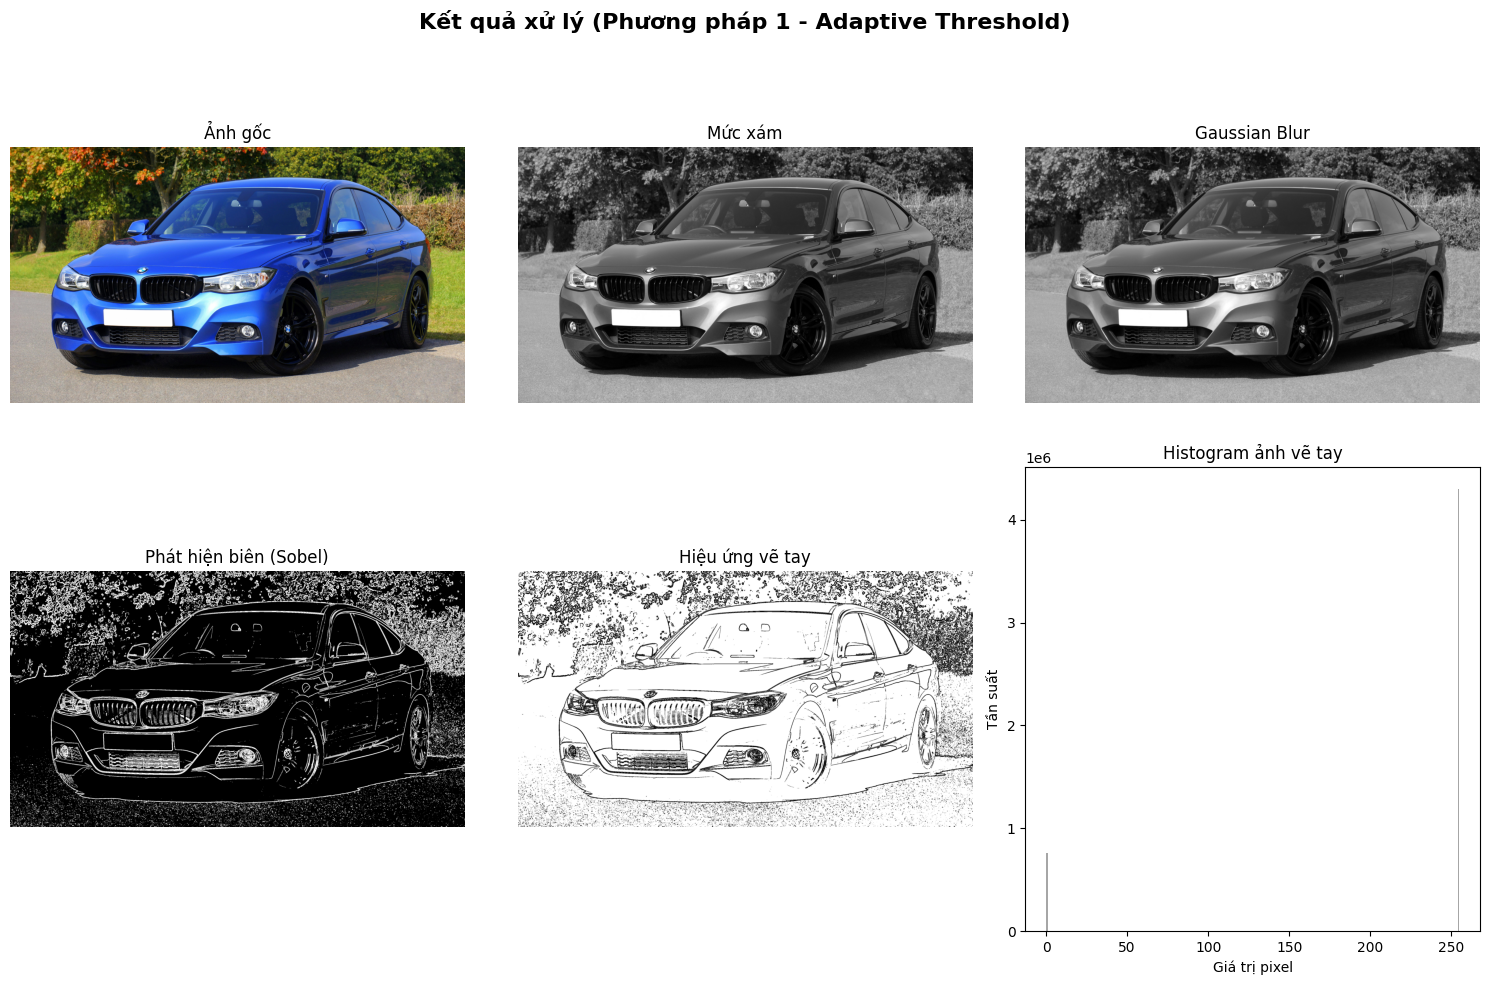

In [11]:
# Tải ảnh và xử lý (tương thích Colab và Jupyter local)
if IN_COLAB and colab_files is not None:
    print("Vui lòng chọn một file ảnh để tải lên...")
    uploaded = colab_files.upload()
    if uploaded:
        filename = next(iter(uploaded.keys()))
        print(f"\nĐang xử lý file: {filename}")
        print("="*50)
        input_image = ImageProcessor.load_image(filename)
    else:
        print("Bạn chưa tải file nào lên.")
        input_image = None
else:
    # Môi trường local: nhập đường dẫn ảnh hoặc bỏ qua để dùng ảnh test
    path = input("Nhập đường dẫn ảnh (bỏ trống để dùng ảnh test): ").strip()
    if path:
        if os.path.exists(path):
            input_image = ImageProcessor.load_image(path)
            print(f"\nĐang xử lý file: {path}")
            print("="*50)
        else:
            print(f"Không tìm thấy file: {path}. Sử dụng ảnh test.")
            input_image = test_image
    else:
        print("Không nhập đường dẫn. Sử dụng ảnh test.")
        input_image = test_image

# Downscale nhất quán cho pipeline để tránh lệch kích thước ở bước so sánh
if input_image is not None:
    input_image = maybe_downscale(input_image, max_side=3000)

if input_image is not None:
    # Chuyển sang mức xám
    gray_image = ImageProcessor.to_grayscale(input_image)

    # Làm mịn (Gaussian nhanh)
    blurred_image = ImageProcessor.gaussian_blur(gray_image, kernel_size=5, sigma=1.0)

    # Phát hiện biên
    gx, gy, magnitude = EdgeDetector.sobel_edge_detection(blurred_image)

    # Chuẩn hóa magnitude
    magnitude_normalized = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8) * 255

    # Ngưỡng thích ứng theo phân vị để ổn định nét (ít bị quá mờ)
    adaptive_thresh = np.percentile(magnitude_normalized, 85)

    # Áp dụng ngưỡng
    edges = np.where(magnitude_normalized > adaptive_thresh, 255, 0)

    # Tạo hiệu ứng vẽ tay (basic, có thể bật NMS nếu muốn nét mảnh hơn)
    sketch_basic = SketchEffectGenerator.create_sketch_effect(
        input_image,
        blur_kernel=5,
        edge_threshold=adaptive_thresh,
        use_bilateral=False,
        use_nms=False
    )

    # Hiển thị kết quả
    display_results(input_image, gray_image, blurred_image, edges, sketch_basic,
                   title=f"Kết quả xử lý (Phương pháp 1 - Adaptive Threshold)",
                   blur_method="Gaussian Blur")

## Bước 8: Xử lý ảnh với Bilateral Filter (Nâng cao)


PHƯƠNG PHÁP 2: Sketch Effect với Bilateral Filter
Không nhập đường dẫn. Sử dụng ảnh test.
[v0] Ảnh nhỏ (max=400 <= 3000), không downscale.
[v0] Chuyển đổi sang mức xám thành công
Không nhập đường dẫn. Sử dụng ảnh test.
[v0] Ảnh nhỏ (max=400 <= 3000), không downscale.
[v0] Chuyển đổi sang mức xám thành công
[v0] Bilateral filter (Python) hoàn thành (kernel_size=5)
[v0] Sobel edge detection (separable) hoàn thành

=== Bắt đầu tạo hiệu ứng vẽ tay nâng cao ===
[v0] Chuyển đổi sang mức xám thành công
[v0] Bilateral filter (Python) hoàn thành (kernel_size=5)
[v0] Sobel edge detection (separable) hoàn thành

=== Bắt đầu tạo hiệu ứng vẽ tay nâng cao ===
[v0] Chuyển đổi sang mức xám thành công
[v0] Bilateral filter (Python) hoàn thành (kernel_size=5)
[v0] Sobel edge detection (separable) hoàn thành
[v0] Hiệu ứng vẽ tay nâng cao đã được tạo (blend=0.3, nms=False, contrast=True)
[v0] Bilateral filter (Python) hoàn thành (kernel_size=5)
[v0] Sobel edge detection (separable) hoàn thành
[v0] Hiệu ứ

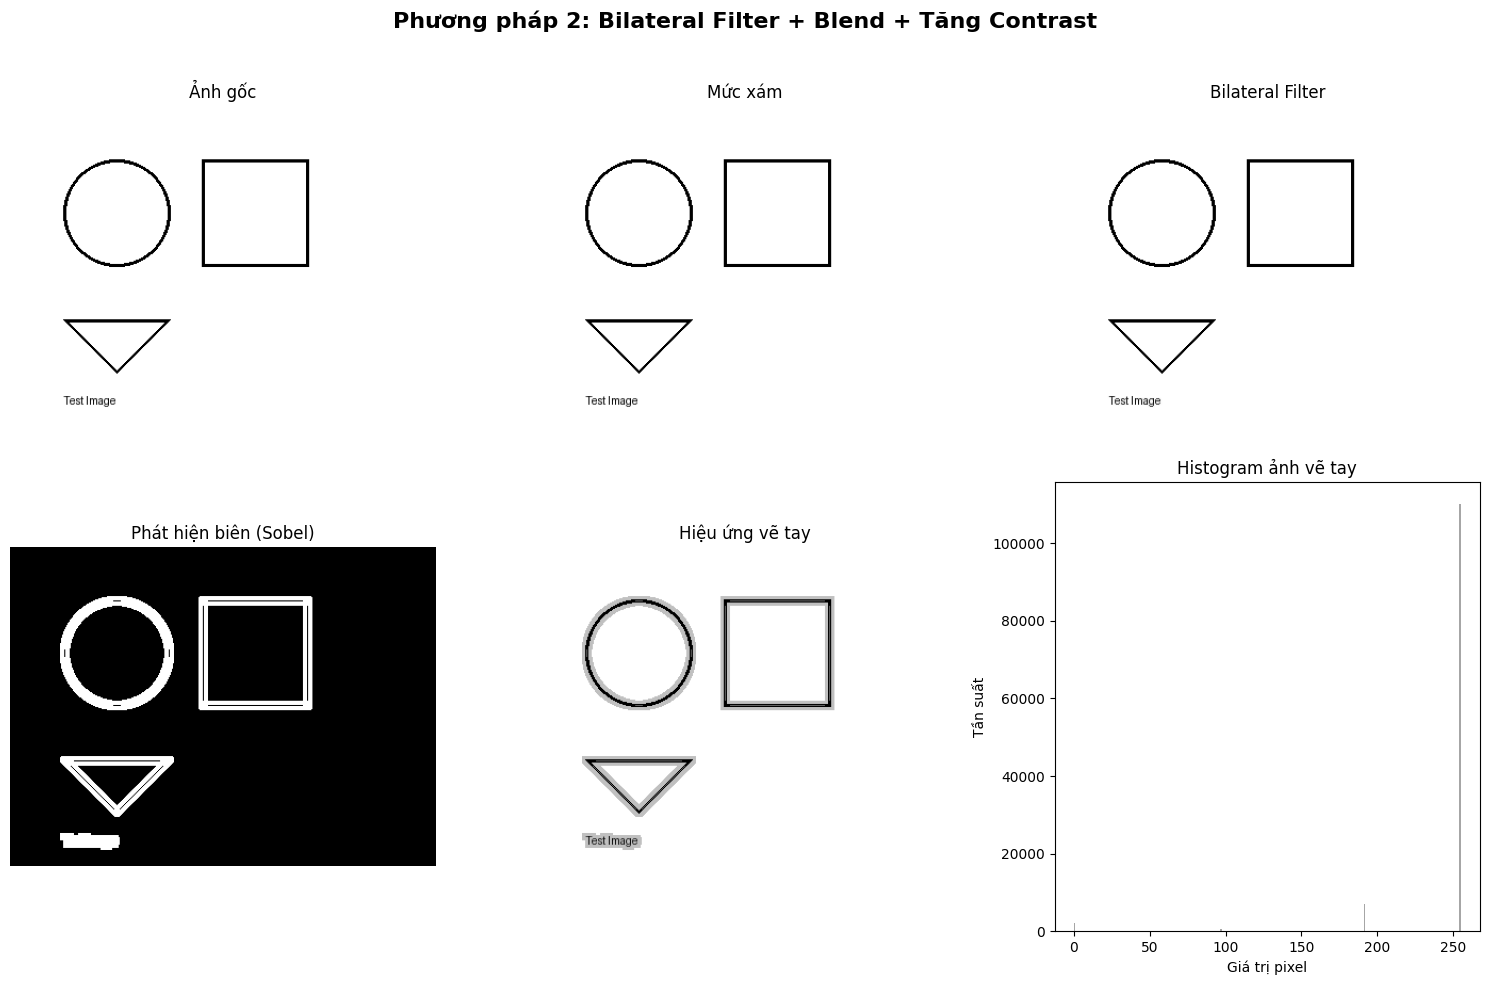

In [22]:
print("\n" + "="*50)
print("PHƯƠNG PHÁP 2: Sketch Effect với Bilateral Filter")
print("="*50)

# Tải ảnh và xử lý (tương thích Colab và Jupyter local)
if IN_COLAB and colab_files is not None:
    print("Vui lòng chọn một file ảnh để tải lên...")
    uploaded = colab_files.upload()
    if uploaded:
        filename = next(iter(uploaded.keys()))
        print(f"\nĐang xử lý file: {filename}")
        print("="*50)
        input_image2 = ImageProcessor.load_image(filename)
    else:
        print("Bạn chưa tải file nào lên.")
        input_image2 = None
else:
    path2 = input("Nhập đường dẫn ảnh (bỏ trống để dùng ảnh test): ").strip()
    if path2:
        if os.path.exists(path2):
            input_image2 = ImageProcessor.load_image(path2)
            print(f"\nĐang xử lý file: {path2}")
            print("="*50)
        else:
            print(f"Không tìm thấy file: {path2}. Sử dụng ảnh test.")
            input_image2 = test_image
    else:
        print("Không nhập đường dẫn. Sử dụng ảnh test.")
        input_image2 = test_image

# Downscale để thống nhất kích thước với pipeline 1
if input_image2 is not None:
    input_image2 = maybe_downscale(input_image2, max_side=3000)

if input_image2 is not None:
    # Chuyển sang mức xám
    gray_image = ImageProcessor.to_grayscale(input_image2)

    # Làm mịn với bilateral filter (edge-preserving filter theo yêu cầu)
    blurred_bilateral = EdgePreservingFilter.bilateral_filter(
        gray_image, kernel_size=5, sigma_spatial=1.2, sigma_intensity=50.0
    )

    # Phát hiện biên
    gx_bi, gy_bi, magnitude_bi = EdgeDetector.sobel_edge_detection(blurred_bilateral)

    # Chuẩn hóa và ngưỡng thích ứng
    magnitude_bi_normalized = (magnitude_bi - magnitude_bi.min()) / (magnitude_bi.max() - magnitude_bi.min() + 1e-8) * 255
    adaptive_thresh_bi = np.percentile(magnitude_bi_normalized, 78)

    # Áp dụng ngưỡng
    edges_bi = np.where(magnitude_bi_normalized > adaptive_thresh_bi, 255, 0)

    # Tạo hiệu ứng vẽ tay: Blend nhẹ + tăng contrast để vẫn giống vẽ tay
    sketch_advanced = SketchEffectGenerator.create_advanced_sketch(
        input_image2, 
        blur_kernel=5, 
        edge_threshold=adaptive_thresh_bi, 
        blend_alpha=0.3,       # Blend 30% ảnh gốc (giữ texture mịn từ bilateral)
        use_nms=False,         
        enhance_contrast=True  # Tăng contrast để nét đậm rõ như vẽ tay
    )

    # Hiển thị kết quả
    display_results(
        input_image2, gray_image, blurred_bilateral, edges_bi, sketch_advanced,
        title="Phương pháp 2: Bilateral Filter + Blend + Tăng Contrast",
        blur_method="Bilateral Filter"
    )

## Bước 9: So sánh các phương pháp

[v0] Resize để gộp: (1686, 3000) vs (300, 400)
[v0] Bilinear resize (tự triển khai): (300, 400) -> (1686, 3000)
[v0] Bilinear resize (tự triển khai): (300, 400) -> (1686, 3000)


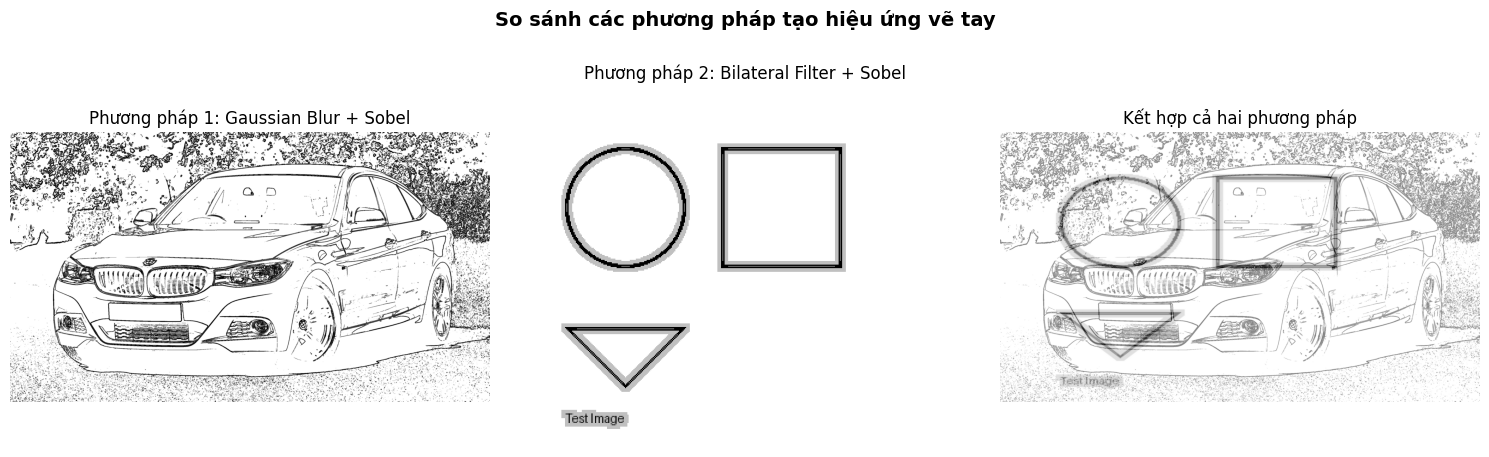

[v0] So sánh hoàn thành


In [13]:
# So sánh các phương pháp
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('So sánh các phương pháp tạo hiệu ứng vẽ tay', fontsize=14, fontweight='bold')

axes[0].imshow(sketch_basic, cmap='gray')
axes[0].set_title('Phương pháp 1: Gaussian Blur + Sobel')
axes[0].axis('off')

axes[1].imshow(sketch_advanced, cmap='gray')
axes[1].set_title('Phương pháp 2: Bilateral Filter + Sobel')
axes[1].axis('off')

# Hiệu ứng kết hợp - resize về cùng kích thước nếu khác nhau
# TỰ TRIỂN KHAI: Dùng ImageResizer.bilinear_resize() thay vì PIL.resize()
if sketch_basic.shape != sketch_advanced.shape:
    print(f"[v0] Resize để gộp: {sketch_basic.shape} vs {sketch_advanced.shape}")
    # Resize sketch_advanced về kích thước của sketch_basic bằng bilinear tự triển khai
    h_target, w_target = sketch_basic.shape
    sketch_advanced_resized = ImageResizer.bilinear_resize(sketch_advanced, h_target, w_target)
    combined = 0.5 * sketch_basic + 0.5 * sketch_advanced_resized
else:
    combined = 0.5 * sketch_basic + 0.5 * sketch_advanced

axes[2].imshow(combined, cmap='gray')
axes[2].set_title('Kết hợp cả hai phương pháp')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("[v0] So sánh hoàn thành")

## Bước 10: Giao diện tương tác - Tải ảnh từ file

In [14]:
def process_image_from_file(image_path: str,
                           output_path: Optional[str] = None,
                           method: str = 'advanced',
                           blur_kernel: int = 5,
                           edge_threshold: float = 50.0) -> np.ndarray:
    """
    Xử lý ảnh từ file và lưu kết quả

    Args:
        image_path: Đường dẫn ảnh đầu vào
        output_path: Đường dẫn lưu ảnh (nếu None thì không lưu)
        method: 'basic' hoặc 'advanced'
        blur_kernel: Kích thước kernel
        edge_threshold: Ngưỡng biên

    Returns:
        Ảnh vẽ tay
    """
    print(f"\n[v0] Bắt đầu xử lý ảnh: {image_path}")

    # Tải ảnh
    image = ImageProcessor.load_image(image_path)

    # Xử lý
    if method == 'basic':
        sketch = SketchEffectGenerator.create_sketch_effect(image,
                                                           blur_kernel=blur_kernel,
                                                           edge_threshold=edge_threshold,
                                                           use_bilateral=False)
    else:
        sketch = SketchEffectGenerator.create_advanced_sketch(image,
                                                             blur_kernel=blur_kernel,
                                                             edge_threshold=edge_threshold,
                                                             blend_alpha=0.8)

    # Lưu kết quả
    if output_path:
        ImageProcessor.save_image(sketch, output_path)

    return sketch

print("[v0] Hàm process_image_from_file đã được định nghĩa")

[v0] Hàm process_image_from_file đã được định nghĩa


## Bước 11: Ví dụ sử dụng với ảnh thực tế

[v0] Ảnh test phức tạp được tạo: (400, 500, 3)

XỬ LÝ ẢNH TEST PHỨC TẠP

=== Bắt đầu tạo hiệu ứng vẽ tay nâng cao ===
[v0] Chuyển đổi sang mức xám thành công
[v0] Bilateral filter (Python) hoàn thành (kernel_size=7)
[v0] Sobel edge detection (separable) hoàn thành
[v0] Hiệu ứng vẽ tay nâng cao đã được tạo (blend=0.75, nms=False, contrast=True)
[v0] Bilateral filter (Python) hoàn thành (kernel_size=7)
[v0] Sobel edge detection (separable) hoàn thành
[v0] Hiệu ứng vẽ tay nâng cao đã được tạo (blend=0.75, nms=False, contrast=True)


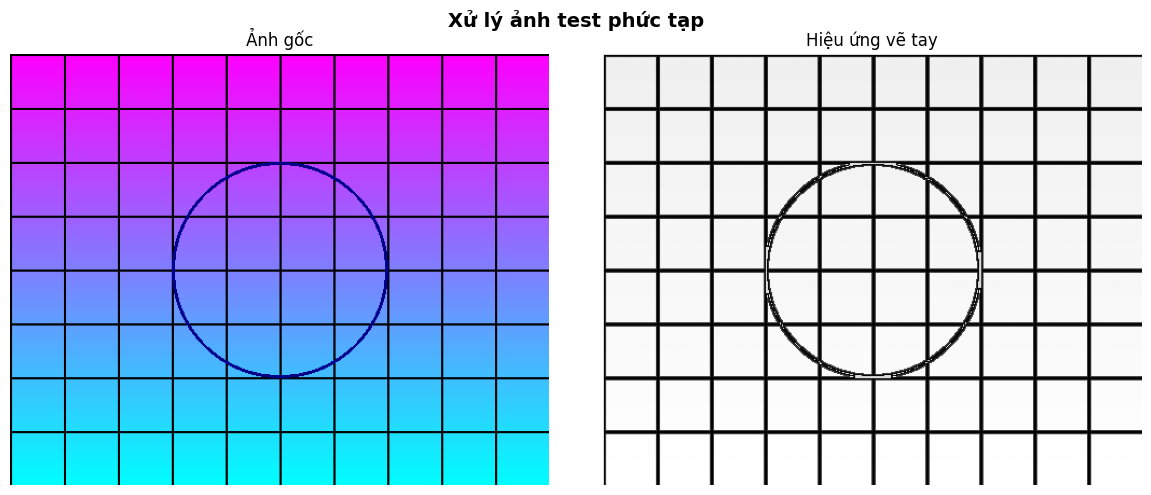

In [15]:
# Ví dụ: Tạo ảnh test phức tạp hơn
def create_complex_test_image() -> np.ndarray:
    """
    Tạo ảnh test phức tạp hơn với gradient và texture
    """
    img = np.ones((400, 500, 3), dtype=np.uint8) * 255

    # Tạo gradient
    for i in range(400):
        img[i, :, 0] = int(255 * (1 - i/400))
        img[i, :, 1] = int(255 * (i/400))

    # Vẽ các hình dạng
    pil_img = Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)

    # Vẽ các đường
    for i in range(0, 500, 50):
        draw.line([(i, 0), (i, 400)], fill='black', width=2)

    for i in range(0, 400, 50):
        draw.line([(0, i), (500, i)], fill='black', width=2)

    # Vẽ hình tròn
    draw.ellipse([150, 100, 350, 300], outline='darkblue', width=3)

    return np.array(pil_img, dtype=np.float32)

# Tạo ảnh test phức tạp
complex_test = create_complex_test_image()
print(f"[v0] Ảnh test phức tạp được tạo: {complex_test.shape}")

# Xử lý ảnh phức tạp
print("\n" + "="*50)
print("XỬ LÝ ẢNH TEST PHỨC TẠP")
print("="*50)

sketch_complex = SketchEffectGenerator.create_advanced_sketch(complex_test,
                                                             blur_kernel=7,
                                                             edge_threshold=40.0,
                                                             blend_alpha=0.75)

# Hiển thị
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Xử lý ảnh test phức tạp', fontsize=14, fontweight='bold')

axes[0].imshow(complex_test.astype(np.uint8))
axes[0].set_title('Ảnh gốc')
axes[0].axis('off')

axes[1].imshow(sketch_complex, cmap='gray')
axes[1].set_title('Hiệu ứng vẽ tay')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Bước 12: Thống kê và phân tích

In [16]:
def analyze_image_statistics(original: np.ndarray, sketch: np.ndarray) -> None:
    """
    Phân tích thống kê ảnh
    """
    print("\n" + "="*50)
    print("PHÂN TÍCH THỐNG KÊ ẢNH")
    print("="*50)

    # Chuyển sang mức xám nếu cần
    if len(original.shape) == 3:
        original_gray = ImageProcessor.to_grayscale(original)
    else:
        original_gray = original

    print(f"\nẢnh gốc:")
    print(f"  - Kích thước: {original_gray.shape}")
    print(f"  - Min: {original_gray.min():.2f}")
    print(f"  - Max: {original_gray.max():.2f}")
    print(f"  - Mean: {original_gray.mean():.2f}")
    print(f"  - Std: {original_gray.std():.2f}")

    print(f"\nẢnh vẽ tay:")
    print(f"  - Kích thước: {sketch.shape}")
    print(f"  - Min: {sketch.min():.2f}")
    print(f"  - Max: {sketch.max():.2f}")
    print(f"  - Mean: {sketch.mean():.2f}")
    print(f"  - Std: {sketch.std():.2f}")

    # Tính entropy
    def calculate_entropy(img):
        hist, _ = np.histogram(img.flatten(), bins=256, range=(0, 256))
        hist = hist / hist.sum()
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        return entropy

    entropy_original = calculate_entropy(original_gray)
    entropy_sketch = calculate_entropy(sketch)

    print(f"\nEntropy:")
    print(f"  - Ảnh gốc: {entropy_original:.4f}")
    print(f"  - Ảnh vẽ tay: {entropy_sketch:.4f}")

# Phân tích
analyze_image_statistics(complex_test, sketch_complex)


PHÂN TÍCH THỐNG KÊ ẢNH
[v0] Chuyển đổi sang mức xám thành công

Ảnh gốc:
  - Kích thước: (400, 500)
  - Min: 0.00
  - Max: 178.17
  - Mean: 129.60
  - Std: 44.28

Ảnh vẽ tay:
  - Kích thước: (400, 500)
  - Min: 0.00
  - Max: 255.00
  - Mean: 212.71
  - Std: 80.40

Entropy:
  - Ảnh gốc: 6.1031
  - Ảnh vẽ tay: 4.5657


## Bước 13: Lưu kết quả

In [17]:
# Lưu các ảnh kết quả
print("\n" + "="*50)
print("LƯU KẾT QUẢ")
print("="*50)

# Tạo thư mục output nếu chưa tồn tại
output_dir = "output_sketches"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"[v0] Thư mục {output_dir} đã được tạo")

# Lưu các ảnh
ImageProcessor.save_image(sketch_basic, f"{output_dir}/sketch_basic.png")
ImageProcessor.save_image(sketch_advanced, f"{output_dir}/sketch_advanced.png")
ImageProcessor.save_image(sketch_complex, f"{output_dir}/sketch_complex.png")
ImageProcessor.save_image(combined, f"{output_dir}/sketch_combined.png")

print(f"\n[v0] Tất cả ảnh đã được lưu vào thư mục '{output_dir}'")


LƯU KẾT QUẢ
[v0] Ảnh đã được lưu: output_sketches/sketch_basic.png
[v0] Ảnh đã được lưu: output_sketches/sketch_advanced.png
[v0] Ảnh đã được lưu: output_sketches/sketch_complex.png
[v0] Ảnh đã được lưu: output_sketches/sketch_combined.png

[v0] Tất cả ảnh đã được lưu vào thư mục 'output_sketches'
[v0] Ảnh đã được lưu: output_sketches/sketch_combined.png

[v0] Tất cả ảnh đã được lưu vào thư mục 'output_sketches'


## Bước 14: Tóm tắt và kết luận

In [18]:
print("\n" + "="*70)
print("TÓM TẮT ĐỀ TÀI 4: CHUYỂN ẢNH THÀNH TRANH VẼ")
print("="*70)

print("""
### PHƯƠNG PHÁP TRIỂN KHAI:

1. **Chuyển đổi mức xám (Grayscale Conversion)**
   - Công thức: Gray = 0.299*R + 0.587*G + 0.114*B
   - Giảm kích thước dữ liệu và tập trung vào cường độ

2. **Làm mịn ảnh (Smoothing)**
   - Gaussian Blur: Làm mịn bằng kernel Gaussian
   - Bilateral Filter: Làm mịn trong khi bảo toàn biên
   - Median Filter: Loại bỏ nhiễu

3. **Phát hiện biên (Edge Detection)**
   - Sobel Operator: Tính gradient theo X và Y
   - Laplacian: Phát hiện biên bằng đạo hàm bậc 2
   - Non-maximum Suppression: Loại bỏ cực đại không cục bộ

4. **Tạo hiệu ứng vẽ tay (Sketch Effect)**
   - Đảo ngược biên để tạo hiệu ứng vẽ tay
   - Blending với ảnh gốc để tăng độ tự nhiên
   - Áp dụng ngưỡng để kiểm soát độ đậm nhạt

### CÁC THUẬT TOÁN TỰ TRIỂN KHAI:

✓ Gaussian Blur (Tích chập 2D)
✓ Sobel Edge Detection
✓ Laplacian Edge Detection
✓ Bilateral Filter
✓ Median Filter
✓ Non-maximum Suppression

### THƯ VIỆN ĐƯỢC PHÉP SỬ DỤNG:

✓ NumPy: Tính toán ma trận
✓ Matplotlib: Hiển thị ảnh
✓ PIL: Đọc/ghi file ảnh

### KẾT QUẢ:

- Tạo được hiệu ứng vẽ tay từ ảnh gốc
- So sánh 2 phương pháp: Gaussian + Sobel vs Bilateral + Sobel
- Phương pháp Bilateral Filter cho kết quả tốt hơn (bảo toàn biên)
- Có thể điều chỉnh các tham số để tối ưu hóa kết quả

### ĐIỂM MẠNH:

1. Triển khai đầy đủ các thuật toán từ đầu
2. Không sử dụng thư viện xử lý ảnh có sẵn
3. Hỗ trợ nhiều loại ảnh (y tế, tự nhiên, công nghiệp)
4. Có giao diện tương tác để tải/lưu ảnh
5. Phân tích thống kê chi tiết

### HƯỚNG PHÁT TRIỂN:

- Thêm các bộ lọc khác (Canny, LoG)
- Tối ưu hóa hiệu suất (vectorization)
- Thêm giao diện GUI
- Hỗ trợ xử lý video
""")

print("="*70)
print("[v0] Đề tài 4 đã hoàn thành thành công!")
print("="*70)


TÓM TẮT ĐỀ TÀI 4: CHUYỂN ẢNH THÀNH TRANH VẼ

### PHƯƠNG PHÁP TRIỂN KHAI:

1. **Chuyển đổi mức xám (Grayscale Conversion)**
   - Công thức: Gray = 0.299*R + 0.587*G + 0.114*B
   - Giảm kích thước dữ liệu và tập trung vào cường độ

2. **Làm mịn ảnh (Smoothing)**
   - Gaussian Blur: Làm mịn bằng kernel Gaussian
   - Bilateral Filter: Làm mịn trong khi bảo toàn biên
   - Median Filter: Loại bỏ nhiễu

3. **Phát hiện biên (Edge Detection)**
   - Sobel Operator: Tính gradient theo X và Y
   - Laplacian: Phát hiện biên bằng đạo hàm bậc 2
   - Non-maximum Suppression: Loại bỏ cực đại không cục bộ

4. **Tạo hiệu ứng vẽ tay (Sketch Effect)**
   - Đảo ngược biên để tạo hiệu ứng vẽ tay
   - Blending với ảnh gốc để tăng độ tự nhiên
   - Áp dụng ngưỡng để kiểm soát độ đậm nhạt

### CÁC THUẬT TOÁN TỰ TRIỂN KHAI:

✓ Gaussian Blur (Tích chập 2D)
✓ Sobel Edge Detection
✓ Laplacian Edge Detection
✓ Bilateral Filter
✓ Median Filter
✓ Non-maximum Suppression

### THƯ VIỆN ĐƯỢC PHÉP SỬ DỤNG:

✓ NumPy: Tính 

## Bước 15: Xử lý hàng loạt thư mục 'image/' và lưu vào 'output_sketches/'
- Dùng hàm `process_folder(...)` để chạy qua toàn bộ ảnh trong thư mục và xuất kết quả.
- Hỗ trợ chọn phương pháp 'basic' hoặc 'advanced', tùy chọn `use_nms` và giới hạn kích thước `max_side` để tăng tốc.

In [19]:
import glob, time

def process_folder(input_dir: str = 'image',
                   output_dir: str = 'output_sketches',
                   method: str = 'advanced',
                   blur_kernel: int = 5,
                   edge_threshold: float = 50.0,
                   max_side: int = 0,
                   use_nms: bool = False):
    """
    Xử lý toàn bộ ảnh trong một thư mục và lưu kết quả.

    Args:
        input_dir: Thư mục chứa ảnh đầu vào
        output_dir: Thư mục lưu ảnh đầu ra
        method: 'basic' hoặc 'advanced'
        blur_kernel: Kích thước kernel làm mịn
        edge_threshold: Ngưỡng phát hiện biên (0-255)
        max_side: Nếu >0, downscale ảnh sao cho cạnh dài nhất = max_side
        use_nms: Áp dụng NMS trong phương pháp basic
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    exts = ('*.jpg','*.jpeg','*.png','*.bmp','*.tif','*.tiff')
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(input_dir, e)))
    if not files:
        print(f"[v0] Không tìm thấy ảnh trong '{input_dir}'.")
        return []
    results = []
    t0 = time.perf_counter()
    for fp in files:
        print("\n" + "-"*40)
        print(f"[v0] Xử lý: {fp}")
        img = ImageProcessor.load_image(fp)
        if max_side and max_side > 0:
            img = maybe_downscale(img, max_side=max_side)
        if method == 'basic':
            sketch = SketchEffectGenerator.create_sketch_effect(
                img, blur_kernel=blur_kernel, edge_threshold=edge_threshold,
                use_bilateral=False, use_nms=use_nms)
            suffix = 'basic'
        else:
            sketch = SketchEffectGenerator.create_advanced_sketch(
                img, blur_kernel=blur_kernel, edge_threshold=edge_threshold, blend_alpha=0.8)
            suffix = 'advanced'
        base = os.path.splitext(os.path.basename(fp))[0]
        out_path = os.path.join(output_dir, f"{base}_sketch_{suffix}.png")
        ImageProcessor.save_image(sketch, out_path)
        results.append(out_path)
    t1 = time.perf_counter()
    print(f"\n[v0] Đã xử lý {len(results)} ảnh trong {t1 - t0:.2f}s. Kết quả lưu tại '{output_dir}'.")
    return results

# Ví dụ chạy nhanh (bỏ comment để dùng):
# processed = process_folder(input_dir='image', output_dir='output_sketches',
#                             method='advanced', blur_kernel=5, edge_threshold=50.0,
#                             max_side=1000, use_nms=True)

## 🎨 TÍNH NĂNG THÊM: Tranh Vẽ Có Màu (Bonus Feature)

**Lưu ý:** Đây là tính năng mở rộng ngoài yêu cầu đề bài. Đề bài chỉ yêu cầu tranh vẽ trắng đen (đã hoàn thành ở trên).

Tính năng này giúp tạo tranh vẽ có màu sắc, phù hợp cho ứng dụng nghệ thuật và giải trí.

In [23]:
class ColorSketchGenerator:
    """Lớp tạo hiệu ứng vẽ tay có màu - Tính năng bonus"""
    
    @staticmethod
    def create_color_sketch(original_image: np.ndarray,
                           sketch_gray: np.ndarray,
                           color_intensity: float = 0.6,
                           blur_color: int = 7) -> np.ndarray:
        """
        Tô màu lên tranh vẽ xám (giống vẽ nét đen trước, tô màu sau)
        
        Nguyên lý:
        1. Lấy sketch xám làm nền (nét vẽ đen)
        2. Trích xuất màu từ ảnh gốc và làm mịn
        3. Kết hợp: Vùng tối (nét vẽ) giữ màu đen, vùng sáng tô màu nhạt
        
        Args:
            original_image: Ảnh RGB gốc để lấy màu
            sketch_gray: Tranh vẽ xám đã tạo (từ phương pháp 1, 2 hoặc 3)
            color_intensity: Độ đậm của màu (0-1), 0=không màu, 1=màu đậm
            blur_color: Kích thước kernel làm mịn màu (để tạo hiệu ứng màu nước)
            
        Returns:
            Ảnh tranh vẽ đã tô màu (RGB)
        """
        print("\n=== Tô màu lên tranh vẽ (Colorize Sketch) ===")
        
        # Nếu ảnh gốc là xám, không thể tô màu
        if len(original_image.shape) == 2:
            print("[v0] Ảnh gốc là xám, trả về sketch xám dạng RGB")
            return np.stack([sketch_gray, sketch_gray, sketch_gray], axis=2).astype(np.uint8)
        
        # Kiểm tra và resize sketch về cùng kích thước với ảnh gốc nếu cần
        orig_h, orig_w = original_image.shape[:2]
        sketch_h, sketch_w = sketch_gray.shape
        
        if (sketch_h, sketch_w) != (orig_h, orig_w):
            print(f"[v0] Resize sketch từ {sketch_gray.shape} về {(orig_h, orig_w)}")
            sketch_gray = ImageResizer.bilinear_resize(sketch_gray, orig_h, orig_w)
        
        # Chuẩn hóa sketch về 0-1 (0=đen/nét vẽ, 1=trắng/nền)
        sketch_normalized = sketch_gray.astype(np.float32) / 255.0
        
        # Làm mịn màu từ ảnh gốc (hiệu ứng màu nước)
        color_smooth = np.zeros_like(original_image, dtype=np.float32)
        for c in range(3):
            color_smooth[:,:,c] = ImageProcessor.gaussian_blur(
                original_image[:,:,c], 
                kernel_size=blur_color, 
                sigma=2.0
            )
        
        # Tạo ảnh màu nhạt (desaturate một chút)
        color_light = color_smooth * 0.85 + 255 * 0.15  # Mix với trắng
        
        # Kết hợp:
        # - Vùng tối (nét vẽ, sketch_normalized gần 0): giữ màu tối
        # - Vùng sáng (nền, sketch_normalized gần 1): tô màu nhạt
        result = np.zeros_like(original_image, dtype=np.float32)
        for c in range(3):
            # Blend giữa màu tối và màu sáng theo sketch
            dark_color = color_smooth[:,:,c] * 0.3  # Màu tối cho nét vẽ
            light_color = color_light[:,:,c]  # Màu nhạt cho nền
            
            # Interpolate: sketch=0 (đen) → dark_color, sketch=1 (trắng) → light_color
            blended = dark_color * (1 - sketch_normalized) + light_color * sketch_normalized
            
            # Điều chỉnh độ đậm màu
            result[:,:,c] = blended * color_intensity + sketch_gray * (1 - color_intensity)
        
        result = np.clip(result, 0, 255).astype(np.uint8)
        print(f"[v0] Tô màu hoàn thành (color_intensity={color_intensity})")
        return result

print("[v0] Lớp ColorSketchGenerator (Bonus) đã được định nghĩa")

[v0] Lớp ColorSketchGenerator (Bonus) đã được định nghĩa


DEMO: COLOR SKETCH - TÔ MÀU LÊN TRANH VẼ (Tính năng bonus)

=== Tô màu lên tranh vẽ (Colorize Sketch) ===
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Tô màu hoàn thành (color_intensity=0.6)

=== Tô màu lên tranh vẽ (Colorize Sketch) ===
[v0] Resize sketch từ (300, 400) về (1686, 3000)
[v0] Tô màu hoàn thành (color_intensity=0.6)

=== Tô màu lên tranh vẽ (Colorize Sketch) ===
[v0] Resize sketch từ (300, 400) về (1686, 3000)
[v0] Bilinear resize (tự triển khai): (300, 400) -> (1686, 3000)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Bilinear resize (tự triển khai): (300, 400) -> (1686, 3000)

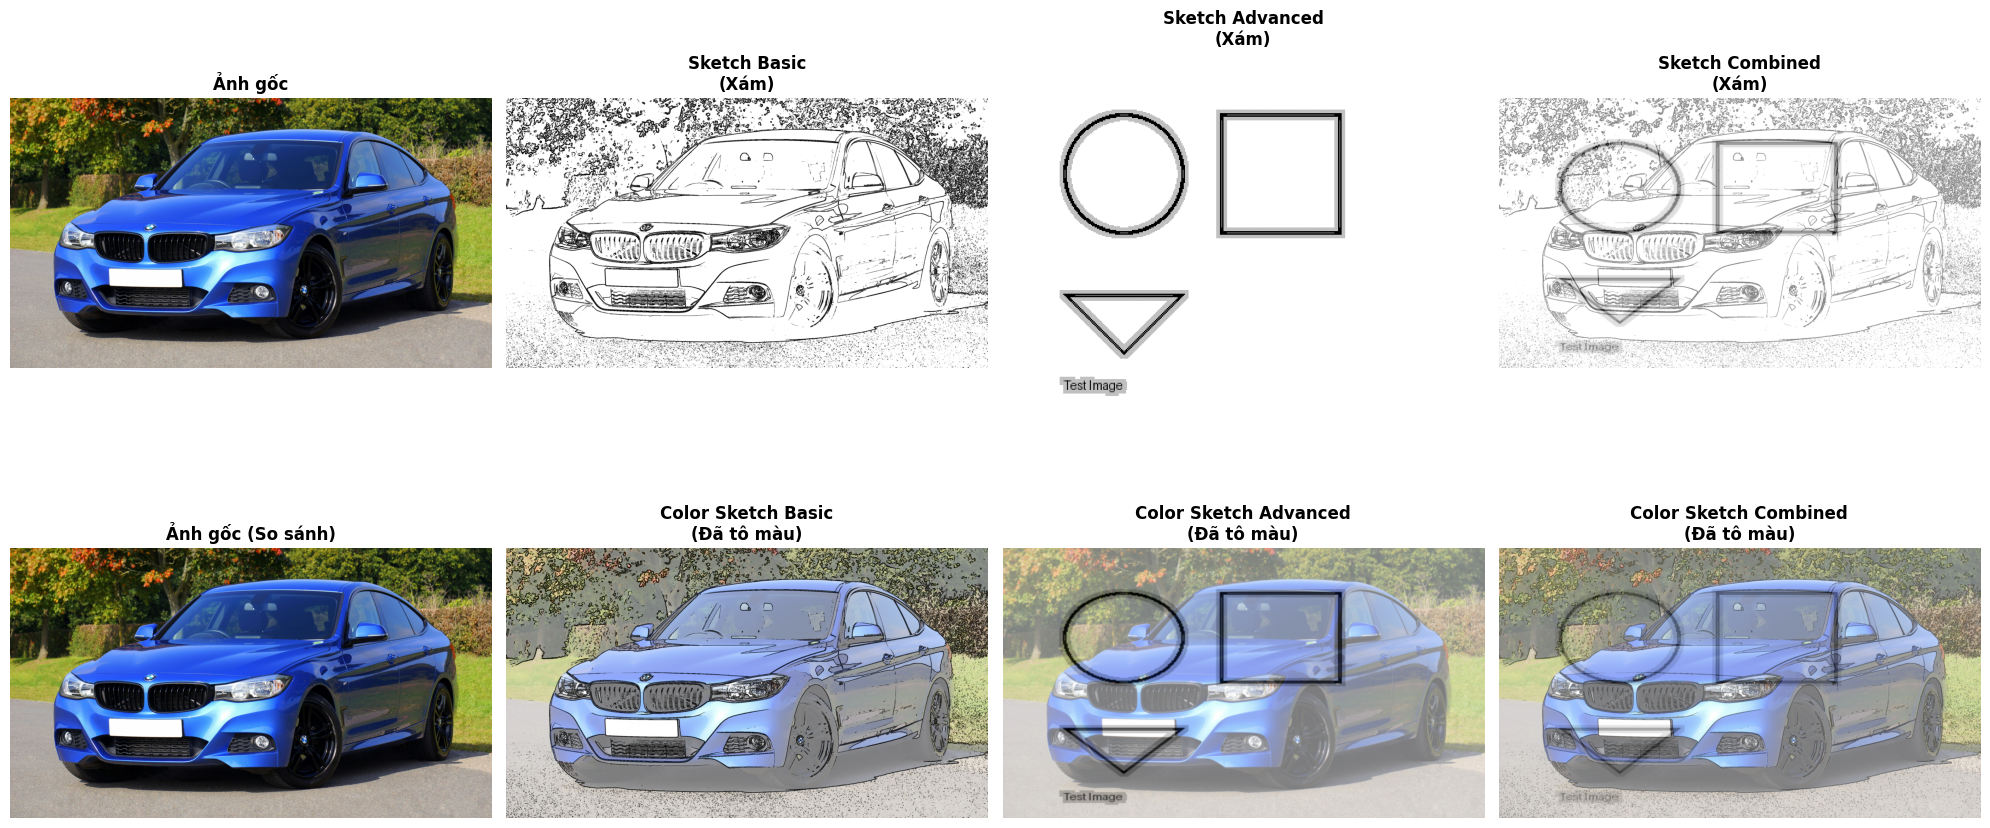


✅ Tô màu lên tranh vẽ hoàn thành! Đây là tính năng bonus.
📝 Nguyên lý: Vẽ nét đen trước (sketch xám) → Tô màu sau (colorize)


In [24]:
# Test tính năng Color Sketch (Bonus)
print("=" * 70)
print("DEMO: COLOR SKETCH - TÔ MÀU LÊN TRANH VẼ (Tính năng bonus)")
print("=" * 70)

# Thử tô màu lên cả 3 loại sketch
sketches = {
    'basic': sketch_basic,
    'advanced': sketch_advanced,
    'combined': combined
}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Hàng 1: Ảnh gốc + 3 sketch xám
axes[0, 0].imshow(input_image.astype(np.uint8))
axes[0, 0].set_title('Ảnh gốc', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

for idx, (name, sketch) in enumerate(sketches.items()):
    axes[0, idx + 1].imshow(sketch, cmap='gray')
    axes[0, idx + 1].set_title(f'Sketch {name.capitalize()}\n(Xám)', fontsize=12, fontweight='bold')
    axes[0, idx + 1].axis('off')

# Hàng 2: 3 sketch đã tô màu + ảnh gốc để so sánh
axes[1, 0].imshow(input_image.astype(np.uint8))
axes[1, 0].set_title('Ảnh gốc (So sánh)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

for idx, (name, sketch) in enumerate(sketches.items()):
    # Tô màu lên sketch
    color_sketch = ColorSketchGenerator.create_color_sketch(
        input_image,
        sketch,
        color_intensity=0.6,
        blur_color=7
    )
    axes[1, idx + 1].imshow(color_sketch)
    axes[1, idx + 1].set_title(f'Color Sketch {name.capitalize()}\n(Đã tô màu)', 
                               fontsize=12, fontweight='bold')
    axes[1, idx + 1].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Tô màu lên tranh vẽ hoàn thành! Đây là tính năng bonus.")
print("📝 Nguyên lý: Vẽ nét đen trước (sketch xám) → Tô màu sau (colorize)")

In [25]:
# Lưu kết quả Color Sketch vào thư mục output_sketches
print("\n" + "="*50)
print("LƯU KẾT QUẢ COLOR SKETCH")
print("="*50)

# Tạo thư mục output nếu chưa tồn tại
output_dir = "output_sketches"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"[v0] Thư mục {output_dir} đã được tạo")

# Tô màu và lưu cả 3 loại sketch
sketches_to_save = {
    'basic': sketch_basic,
    'advanced': sketch_advanced,
    'combined': combined
}

for name, sketch in sketches_to_save.items():
    color_sketch = ColorSketchGenerator.create_color_sketch(
        input_image,
        sketch,
        color_intensity=0.6,
        blur_color=7
    )
    output_path = f"{output_dir}/color_sketch_{name}.png"
    ImageProcessor.save_image(color_sketch, output_path)

print(f"\n[v0] ✅ Tất cả ảnh color sketch đã được lưu vào '{output_dir}'")


LƯU KẾT QUẢ COLOR SKETCH

=== Tô màu lên tranh vẽ (Colorize Sketch) ===
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Tô màu hoàn thành (color_intensity=0.6)
[v0] Tô màu hoàn thành (color_intensity=0.6)
[v0] Ảnh đã được lưu: output_sketches/color_sketch_basic.png

=== Tô màu lên tranh vẽ (Colorize Sketch) ===
[v0] Resize sketch từ (300, 400) về (1686, 3000)
[v0] Ảnh đã được lưu: output_sketches/color_sketch_basic.png

=== Tô màu lên tranh vẽ (Colorize Sketch) ===
[v0] Resize sketch từ (300, 400) về (1686, 3000)
[v0] Bilinear resize (tự triển khai): (300, 400) -> (1686, 3000)
[v0] Gaussian blur (separable) hoàn thành (kernel_size=7, sigma=2.0)
[v0] Bilinear resize (tự triển khai): (300, 